In [ ]:
!pip install --upgrade yfinance
!pip install pandas_ta fredapi statsmodels


In [ ]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import time

Getting data from Yahoo Finance

In [ ]:

# Primary stock (AMZN) historical data
ticker = "AMZN"
stock = yf.Ticker(ticker)
start_date = "2010-01-01"
end_date = "2025-01-01"
# historical price data
price_df = stock.history(start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]
price_df.index = pd.to_datetime(price_df.index)
price_df.index = price_df.index.strftime('%Y-%m-%d')

# Macroeconomic proxy data
macroeconomics = ["DX-Y.NYB", "CL=F", "^VIX", "GC=F"]
macroeconomic_data = {}
for factor in macroeconomics:
    factor_df = yf.Ticker(factor).history(start=start_date, end=end_date, interval='1d')[["Close"]].rename(columns={'Close':f"{factor}_Close"})
    factor_df.index = factor_df.index.strftime('%Y-%m-%d')
    macroeconomic_data[factor] = factor_df
macroeconomic_df = pd.concat(macroeconomic_data.values(), axis=1)

# Macroeconomic Indicators Using FRED API
fred_api_key = "ab78d7d29ca7f4ba6dd2b39124cf25cf"
fred = Fred(api_key=fred_api_key)

# 10-Year Treasury Yield
treasury_series = fred.get_series('DGS10', start_date, end_date)
treasury_df = pd.DataFrame(treasury_series, columns=['10Y_Treasury_Yield'])
treasury_df.index = pd.to_datetime(treasury_df.index)
treasury_df.index = treasury_df.index.strftime('%Y-%m-%d')

'''
# Unemployment Rate
unrate_series = fred.get_series('UNRATE', start_date, end_date)
unrate_df = pd.DataFrame(unrate_series, columns=['Unemployment_Rate'])
unrate_df.index = pd.to_datetime(unrate_df.index)
unrate_df.index = unrate_df.index.strftime('%Y-%m-%d')


# Consumer Price Index (CPI)
cpi_series = fred.get_series('CPIAUCSL', start_date, end_date)
cpi_df = pd.DataFrame(cpi_series, columns=['CPI'])
cpi_df.index = pd.to_datetime(cpi_df.index)
cpi_df.index = cpi_df.index.strftime('%Y-%m-%d')
'''

# Competitor data
competitors = ["MSFT", "GOOGL", "AAPL", "META", "WMT"]
competitor_data = {}
for comp in competitors:
    comp_df = yf.Ticker(comp).history(start=start_date, end=end_date)[["Close"]].rename(columns={'Close':f"{comp}_Close"})
    competitor_data[comp] = comp_df
    comp_df.index = comp_df.index.strftime('%Y-%m-%d')
competitor_df = pd.concat(competitor_data.values(), axis=1)


In [ ]:
#Merge datasets

dfs = [price_df, macroeconomic_df, competitor_df, treasury_df]

merged_df = pd.concat(dfs, axis=1, join="inner")

data = merged_df.bfill()

data.index.name = 'Date'

print("Merged Dataset for GAN Training:")
data

Merged Dataset for GAN Training:


,Open,High,Low,Close,Volume,DX-Y.NYB_Close,CL=F_Close,^VIX_Close,GC=F_Close,MSFT_Close,GOOGL_Close,AAPL_Close,META_Close,WMT_Close,10Y_Treasury_Yield
Date,,,,,,,,,,,,,,,
2010-01-04,6.812500,6.830500,6.657000,6.695000,151998000,77.529999,81.510002,20.040001,1117.699951,23.254051,15.609803,6.440332,38.050663,13.048595,3.85
2010-01-05,6.671500,6.774000,6.590500,6.734500,177038000,77.620003,81.769997,19.350000,1118.099976,23.261557,15.541063,6.451467,38.050663,12.918658,3.77
2010-01-06,6.730000,6.736500,6.582500,6.612500,143576000,77.489998,83.180000,19.160000,1135.900024,23.118813,15.149293,6.348846,38.050663,12.889784,3.85
2010-01-07,6.600500,6.616000,6.440000,6.500000,220604000,77.910004,82.660004,19.059999,1133.099976,22.878380,14.796625,6.337110,38.050663,12.897008,3.85
2010-01-08,6.528000,6.684000,6.451500,6.676000,196610000,77.470001,82.750000,18.129999,1138.199951,23.036165,14.993880,6.379241,38.050663,12.832036,3.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,226.940002,229.139999,226.130005,229.050003,15007500,108.260002,70.099998,14.270000,2620.000000,438.450836,195.884399,257.916443,607.209778,92.426186,4.59
2024-12-26,228.500000,228.500000,226.669998,227.050003,16146700,108.129997,69.620003,14.730000,2638.800049,437.233276,195.375000,258.735504,602.813660,92.535889,4.58
2024-12-27,225.600006,226.029999,220.899994,223.750000,27367100,108.000000,70.599998,15.950000,2617.199951,429.668457,192.538254,255.309296,599.276855,91.408981,4.62


In [ ]:
data['pct_change'] = (data['Close'] - data['Close'].shift(1))/ data['Close'].shift(1)
data['log_change'] = np.log(data['Close']/ data['Close'].shift(1))

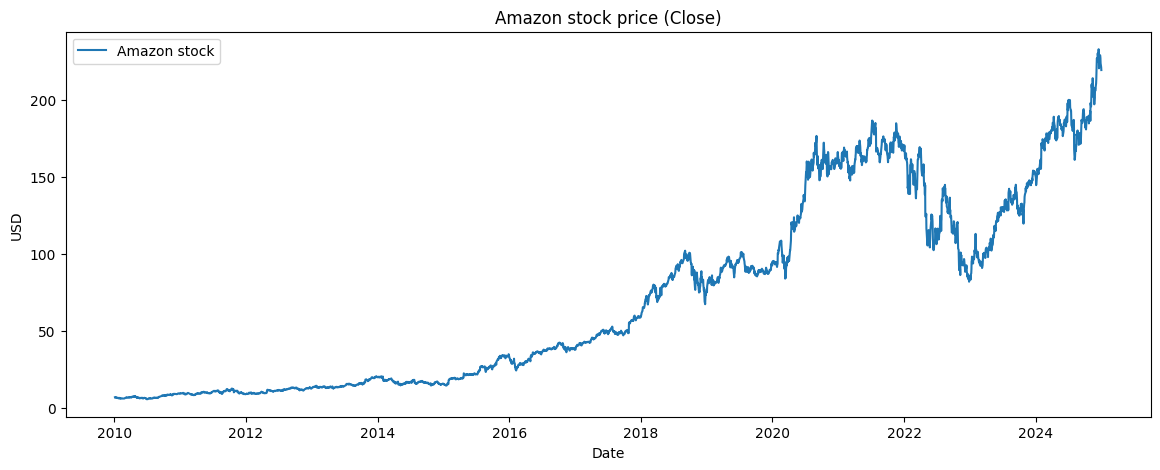

In [ ]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(pd.to_datetime(data.index), data['Close'], label='Amazon stock')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Amazon stock price (Close)')
plt.legend()
plt.show()


In [ ]:

data['7ma'] = ta.ema(data['Close'], 7)
data['14ma'] = ta.ema(data['Close'], 14)
data['21ma'] = ta.ema(data['Close'], 21)
data['7macd'] = ta.macd(data['Close'], 3, 11, 7)['MACD_3_11_7']
data['14macd'] = ta.macd(data['Close'], 7, 21, 14)['MACD_7_21_14']
data['7rsi'] = ta.rsi(data['Close'], 7)
data['14rsi'] = ta.rsi(data['Close'], 14)
data['21rsi'] = ta.rsi(data['Close'], 21)
bbands = ta.bbands(data['Close'], 7)
data['7upper'] = bbands['BBU_7_2.0']
data['7middle'] = bbands['BBM_7_2.0']
data['7lower'] = bbands['BBL_7_2.0']

bbands = ta.bbands(data['Close'], 14)
data['14upper'] = bbands['BBU_14_2.0']
data['14middle'] = bbands['BBM_14_2.0']
data['14lower'] = bbands['BBL_14_2.0']

bbands = ta.bbands(data['Close'], 21)
data['21upper'] = bbands['BBU_21_2.0']
data['21middle'] = bbands['BBM_21_2.0']
data['21lower'] = bbands['BBL_21_2.0']
data['14rsv'] = ta.stoch(data['High'], data['Low'], data['Close'], 14)['STOCHk_14_3_3']
data['21rsv'] = ta.stoch(data['High'], data['Low'], data['Close'], 21)['STOCHk_21_3_3']

In [ ]:
# fill any NaN or 0 data with interpolated data

data = data.interpolate(method='linear')
data = data.fillna(method='bfill')
data = data.fillna(method='ffill')

# Replace any remaining NaN or 0 values with  the mean
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(data.mean())


<ipython-input-90-89749adab10f>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill')
<ipython-input-90-89749adab10f>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [ ]:
data_combine = data

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.subplot(2, 1, 1)
    plt.plot(dataset['7ma'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['21ma'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['21upper'],label='Upper Band', color='c')
    plt.plot(dataset['21lower'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['21lower'], dataset['21upper'], alpha=0.35)
    plt.title('Technical indicators for AMZN - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  #

    plt.show()

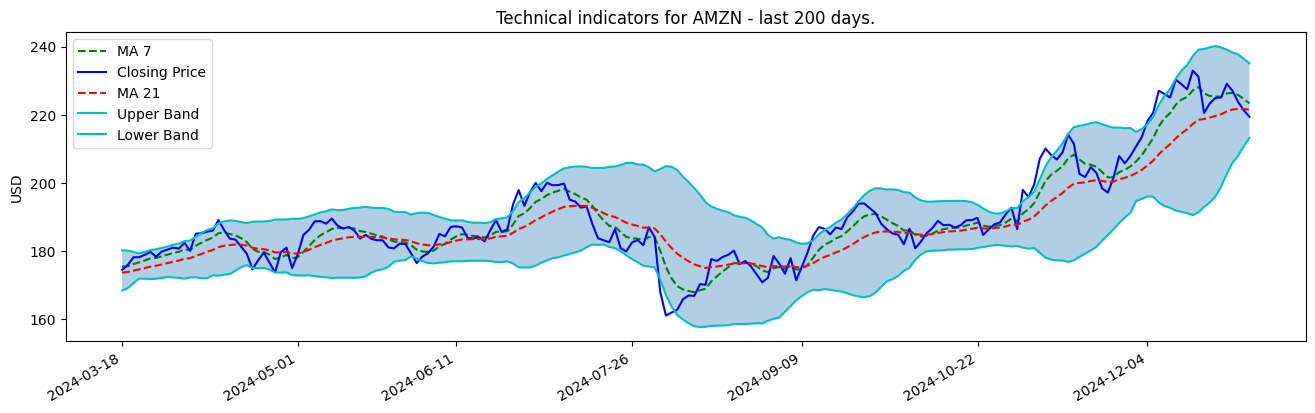

In [ ]:
plot_technical_indicators(data, 200)


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return n

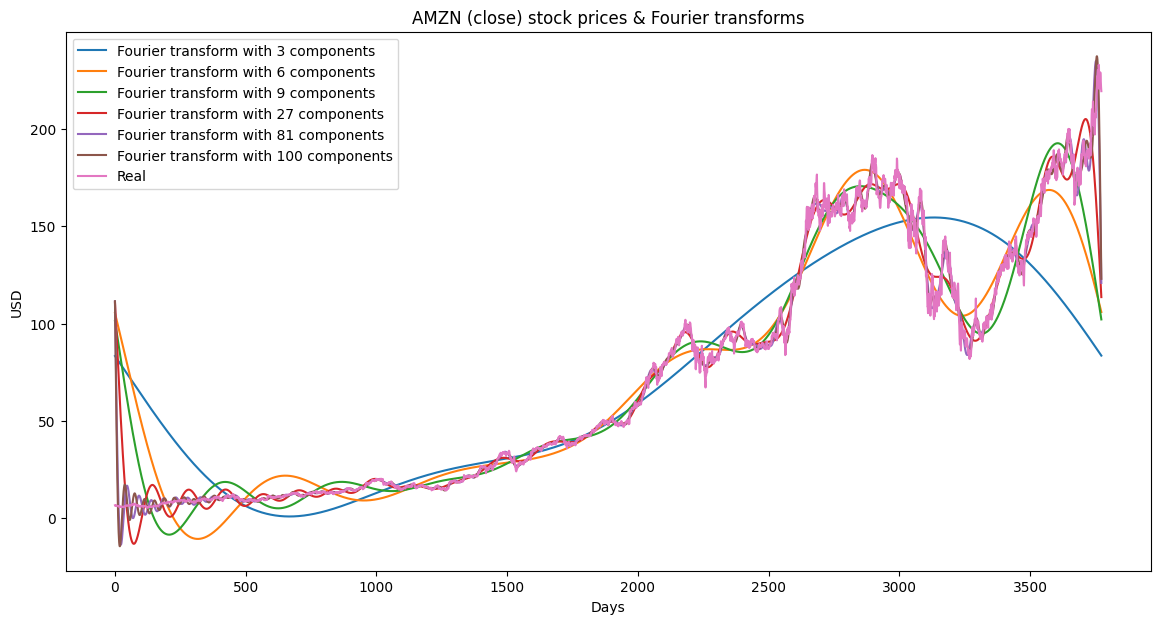

In [ ]:
close_fft = np.fft.fft((data_combine['Close'].values))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 27, 81, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_] = 0
    data_combine[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10)
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_combine['Close'].values,  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('AMZN (close) stock prices & Fourier transforms')
plt.legend()
plt.show()


In [ ]:
data_combine['FT_3components'] = data_combine['FT_3components'].astype('float')
data_combine['FT_6components'] = data_combine['FT_6components'].astype('float')
data_combine['FT_9components'] = data_combine['FT_9components'].astype('float')
data_combine['FT_27components'] = data_combine['FT_27components'].astype('float')
data_combine['FT_81components'] = data_combine['FT_81components'].astype('float')
data_combine['FT_100components'] = data_combine['FT_100components'].astype('float')
data_combine.head()

/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype

,Open,High,Low,Close,Volume,DX-Y.NYB_Close,CL=F_Close,^VIX_Close,GC=F_Close,MSFT_Close,...,21middle,21lower,14rsv,21rsv,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.8125,6.8305,6.6570,6.6950,151998000,77.529999,81.510002,20.040001,1117.699951,23.254051,...,6.328643,5.841435,8.343372,17.794448,83.373363,105.438692,101.280522,110.903727,111.447762,111.489612
2010-01-05,6.6715,6.7740,6.5905,6.7345,177038000,77.620003,81.769997,19.350000,1118.099976,23.261557,...,6.328643,5.841435,8.343372,17.794448,83.175939,104.887839,100.395610,108.171702,102.021946,99.979198
2010-01-06,6.7300,6.7365,6.5825,6.6125,143576000,77.489998,83.180000,19.160000,1135.900024,23.118813,...,6.328643,5.841435,8.343372,17.794448,82.978456,104.335989,99.510360,105.431034,92.669170,88.586995
2010-01-07,6.6005,6.6160,6.4400,6.5000,220604000,77.910004,82.660004,19.059999,1133.099976,22.878380,...,6.328643,5.841435,8.343372,17.794448,82.780915,103.783167,98.624849,102.683694,83.448951,77.419263
2010-01-08,6.5280,6.6840,6.4515,6.6760,196610000,77.470001,82.750000,18.129999,1138.199951,23.036165,...,6.328643,5.841435,8.343372,17.794448,82.583318,103.229397,97.739153,99.931658,74.418983,66.578335


In [ ]:
data_combine.to_csv('./data_post_covid.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [ ]:
def check_data_quality(df):
    """
    Perform data quality checks for financial time series data.

    """
    results = {}

    # Check for missing values
    results['missing_values'] = df.isnull().sum()

    # Plot time series
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    df['Close'].plot(ax=ax[0], title='Closing Price Over Time')
    df['Volume'].plot(ax=ax[1], title='Volume Over Time')
    plt.tight_layout()
    plt.show()

    # Check Heteroskedasticity (Breusch-Pagan Test)
    X = add_constant(df.drop(columns=['Close']))
    y = df['Close']  # Target
    model = OLS(y, X).fit()
    _, pval_bp, _, _ = het_breuschpagan(model.resid, X)
    results['heteroskedasticity_pval'] = pval_bp

    # Plot Residuals vs. Fitted
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, model.resid, alpha=0.5)
    plt.title('Residuals vs. Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

    # Check Multicollinearity (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    results['VIF'] = vif_data


    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Check Serial Correlation (Durbin-Watson & ACF/PACF)
    dw_statistic = model.summary2().tables[1].iloc[2][1] # Accessing the Durbin-Watson statistic directly
    results['durbin_watson_stat'] = dw_statistic

    # Plot ACF and PACF
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(model.resid, lags=20, ax=ax[0])
    plot_pacf(model.resid, lags=20, ax=ax[1])
    plt.tight_layout()
    plt.show()

    return results

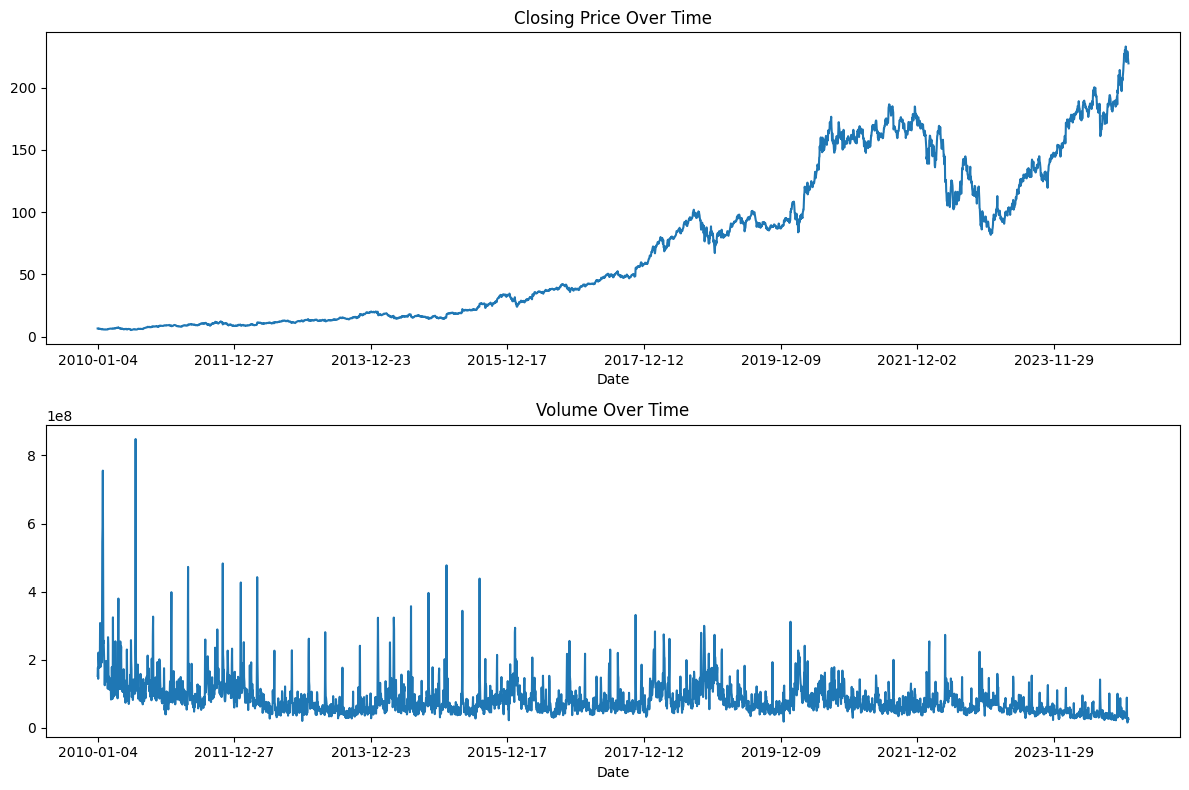

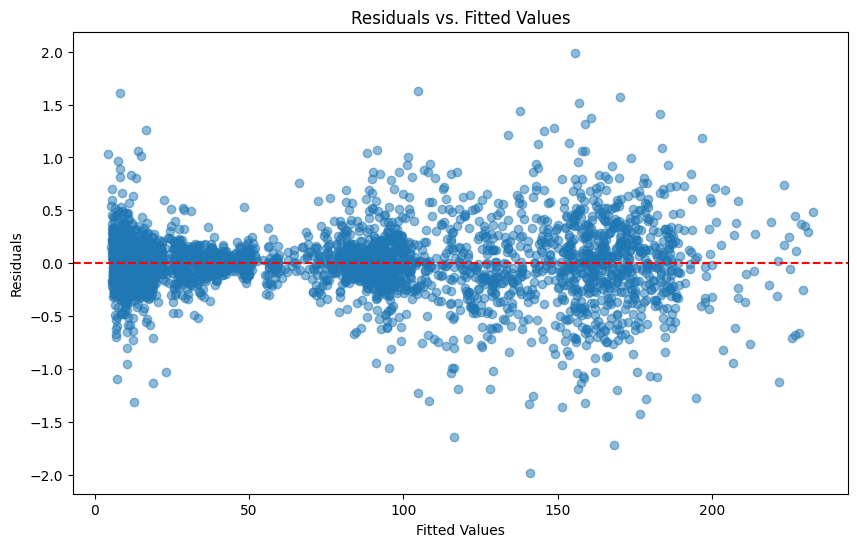

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


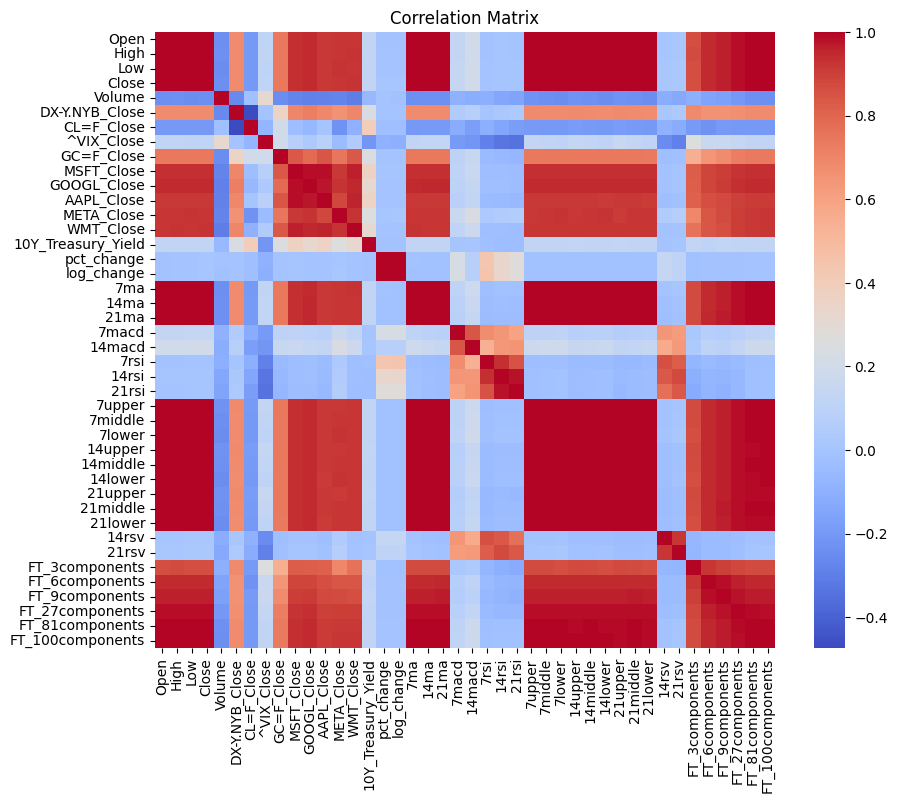

<ipython-input-99-92bf0c702def>:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dw_statistic = model.summary2().tables[1].iloc[2][1] # Accessing the Durbin-Watson statistic directly


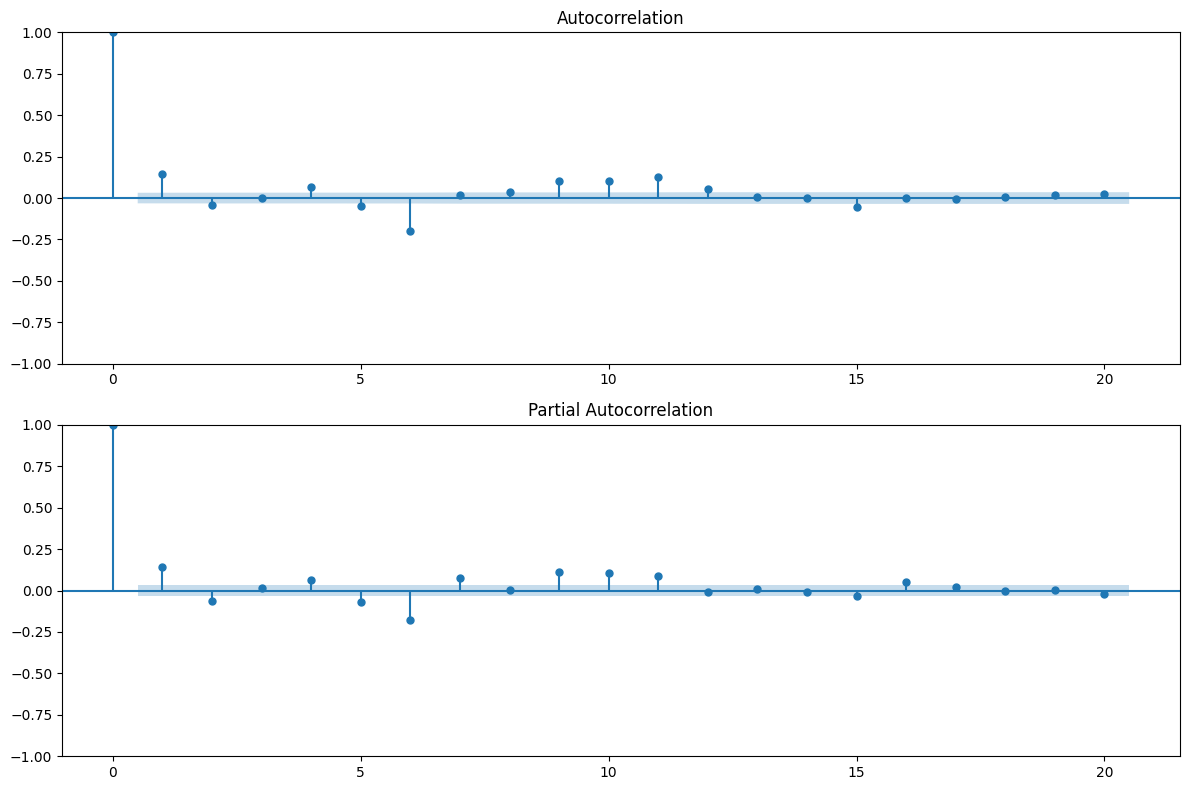

Missing Values:
 Open                  0
High                  0
Low                   0
Close                 0
Volume                0
DX-Y.NYB_Close        0
CL=F_Close            0
^VIX_Close            0
GC=F_Close            0
MSFT_Close            0
GOOGL_Close           0
AAPL_Close            0
META_Close            0
WMT_Close             0
10Y_Treasury_Yield    0
pct_change            0
log_change            0
7ma                   0
14ma                  0
21ma                  0
7macd                 0
14macd                0
7rsi                  0
14rsi                 0
21rsi                 0
7upper                0
7middle               0
7lower                0
14upper               0
14middle              0
14lower               0
21upper               0
21middle              0
21lower               0
14rsv                 0
21rsv                 0
FT_3components        0
FT_6components        0
FT_9components        0
FT_27components       0
FT_81components       0

In [ ]:
results = check_data_quality(data_combine)

print("Missing Values:\n", results['missing_values'])
print("\nHeteroskedasticity p-value:", results['heteroskedasticity_pval'])
print("\nVIF Scores:\n", results['VIF'])
print("\nDurbin-Watson Statistic:", results['durbin_watson_stat'])